<a href="https://colab.research.google.com/github/Black3rror/AI/blob/master/Playground/Blob_AEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

To implement an autoencoder for blob problem and see how disentangled AE can learn **useful** features

# Importing stuff

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense

import matplotlib.pyplot as plt
import time

# Functions

In [ ]:
"""
@param force: list of neurons [with their force_val]. 
              like [[3, 0.3], [15, 0.8]] or [[3], [15]]
"""
def force_neurons(inputs, force = None):
  out = inputs
  if force is not None:
    for neuron in force:
      out[:, neuron[0]] = neuron[1]
  return out

In [ ]:
"""
@BUG: x or y equal to 0 is not acceptable
      temporarily we change them to 1
"""
def blob_gen(X, Y, S, R, elongation = 2, img_size = 320):
  assert len(X) == len(Y) == len(S) == len(R)
  if img_size % 2 ==1:
    img_size += 1

  imgs = np.zeros((len(X), img_size, img_size))
  i = np.arange(-img_size//2, img_size//2).reshape(-1, 1)
  j = np.arange(-img_size//2, img_size//2).reshape(1, -1)
  for n, (x, y, s, r) in enumerate(zip(X, Y, S, R)):
    sin = np.sin(r)
    cos = np.cos(r)
    sin2 = sin * sin
    cos2 = cos * cos

    term1 = (cos2 + sin2 / 4) * i*i
    term2 = -3/2 * cos * sin * i * j
    term3 = (sin2 + cos2 / 4) * j*j

    oval = (term1 + term2 + term3 < s)
    if x == 0:
      x = 1
    if y == 0:
      y = 1
    if x >= 0 and y >= 0:
      imgs[n] = np.pad(oval,((x,0),(y,0)), mode='constant')[:-x, :-y]
    elif x >= 0 and y < 0:
      imgs[n] = np.pad(oval,((x,0),(0,-y)), mode='constant')[:-x, -y:]
    elif x < 0 and y >= 0:
      imgs[n] = np.pad(oval,((0,-x),(y,0)), mode='constant')[-x:, :-y]
    elif x < 0 and y < 0:
      imgs[n] = np.pad(oval,((0,-x),(0,-y)), mode='constant')[-x:, -y:]
  
  return imgs

In [ ]:
def gen_samples(count, img_size = 320):
  s_interval = img_size//5
  S_domain = np.arange(s_interval, s_interval*7, s_interval)
  R_domain = np.arange(40) * np.pi/20
  img_bound = int(0.7 * img_size)

  X = (img_bound * np.random.rand(count) - img_bound//2).astype(int)
  Y = (img_bound * np.random.rand(count) - img_bound//2).astype(int)
  S = S_domain[(len(S_domain) * np.random.rand(count)).astype(int)]
  R = R_domain[(len(R_domain) * np.random.rand(count)).astype(int)]

  return blob_gen(X, Y, S, R, img_size = img_size)

# Initialization

In [ ]:
#assert len(tf.config.list_physical_devices('GPU')) > 0

img_size = 64

testX = gen_samples(1000, img_size)
testX = testX.reshape(1000, -1)

# Gradient tape computation

In [ ]:
batch_size = 32
batchs_per_epoch = 2000
epochs = 10
h_units = 10
loss_func = keras.losses.MeanSquaredError()
lambd = 0.01
opt = keras.optimizers.Adam(learning_rate=0.001)

# layers
dense1 = Dense(128, activation='relu', input_shape = (img_size**2,))
dense2 = Dense(64, activation='relu')
dense_m = Dense(h_units, activation='relu')
dense_v = Dense(h_units, activation='relu')
dense4 = Dense(64, activation='relu')
dense5 = Dense(128, activation='relu')
dense6 = Dense(img_size**2, activation='sigmoid')

for i in range(epochs):
  print("Epoch: ", i)
  epoch_loss = 0
  tic = time.time()

  for step in range(batchs_per_epoch):
    batchX = gen_samples(batch_size, img_size)
    batchX = batchX.reshape((batch_size, -1))
    with tf.GradientTape() as tape:
      x = dense1(batchX)
      x = dense2(x)
      m = dense_m(x)
      v = dense_v(x)
      x = m + v * tf.random.normal(v.shape)
      x = dense4(x)
      x = dense5(x)
      x = dense6(x)

      reg_loss = tf.reduce_mean((v - 1) ** 2) + tf.reduce_mean((m - 0) ** 2)
      loss = loss_func(batchX, x) + lambd * reg_loss

    trainable_vars = dense1.trainable_weights + dense2.trainable_weights + \
                     dense_m.trainable_weights + dense_v.trainable_weights + \
                     dense4.trainable_weights + dense5.trainable_weights + \
                     dense6.trainable_weights
    grads = tape.gradient(loss, trainable_vars)
    opt.apply_gradients(zip(grads, trainable_vars))

    epoch_loss += loss

    if step % 200 == 0:
      print("\tStep %d:    loss = %.5f,    reg_loss = %.3f" % 
            (step, epoch_loss.numpy()/(step+1), reg_loss))

  # epoch ended, validate it
  x = dense1(testX)
  x = dense2(x)
  m = dense_m(x)
  v = dense_v(x)
  x = m + v * tf.random.normal(v.shape)
  x = dense4(x)
  x = dense5(x)
  x = dense6(x)
  val_loss = loss_func(testX, x)
  
  toc = time.time()
  
  print("Epoch %d ended in %.2fs.    loss = %.4f,    val_loss = %.4f" % 
        (i, toc-tic, epoch_loss.numpy()/(step+1), val_loss.numpy()))

Epoch:  0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

	Step 0:    loss = 0.25836,    reg_loss = 0.833
	Step 200:    loss = 0.07847,    reg_loss = 0.152
	Step 400:    loss = 0.06855,    reg_loss = 0.165
	Step 600:    loss = 0.06502,    reg_loss = 0.140
	Step 800:    loss = 0.06292,    reg_loss = 0.191
	Step 1000:    loss = 0.06109,    reg_loss = 0.185
	Step 1200:    loss = 0.05949,    reg_loss = 0.177
	Step 1400:    loss = 0.05828,    reg_loss = 0.214
	Step 1600:    loss = 0.05726,    reg_loss = 0.202
	Step 1800:    loss = 0.05642,    reg_loss = 0

# Show results

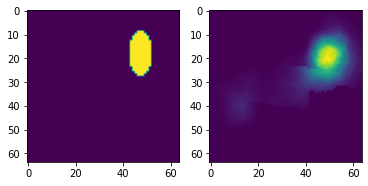

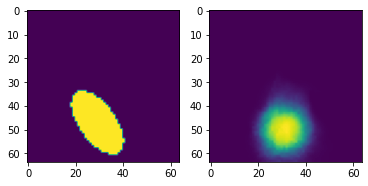

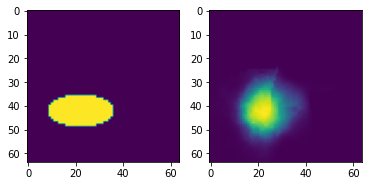

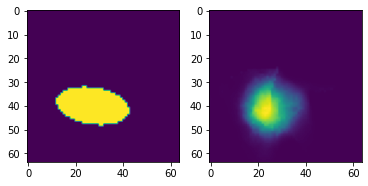

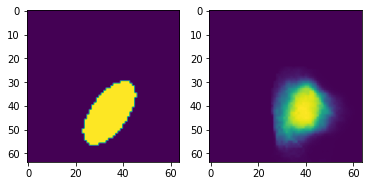

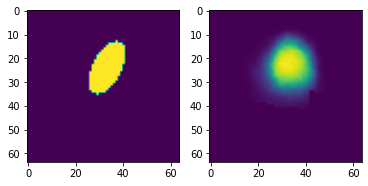

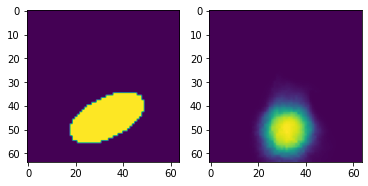

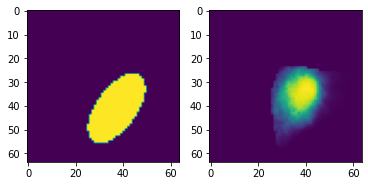

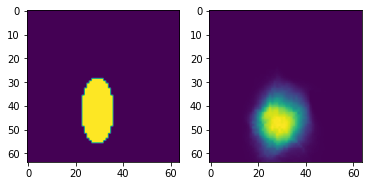

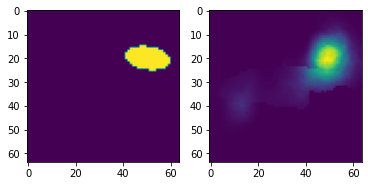

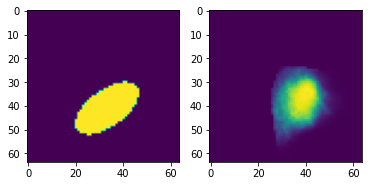

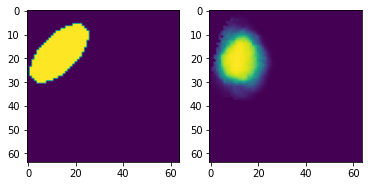

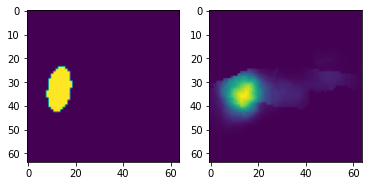

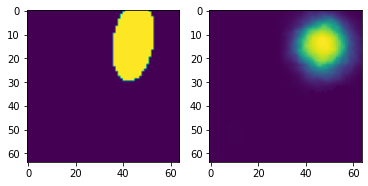

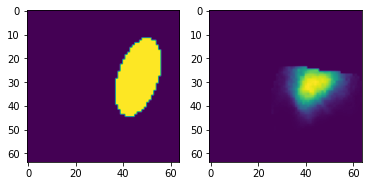

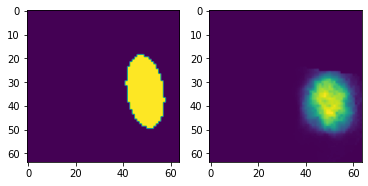

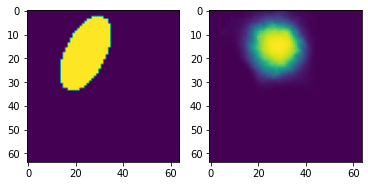

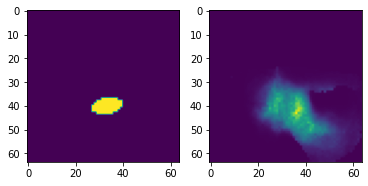

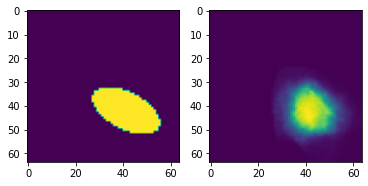

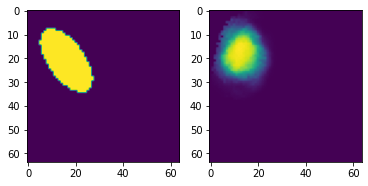

In [ ]:
indx = (len(testX) * np.random.rand(20)).astype(int)

x = dense1(testX[indx])
x = dense2(x)
m = dense_m(x)
v = dense_v(x)
x = m + v * tf.random.normal(v.shape)
x = dense4(x)
x = dense5(x)
pred = dense6(x).numpy()

pred = pred.reshape(len(indx), img_size, img_size)
original = testX[indx].reshape(len(indx), img_size, img_size)

for i in range(len(indx)):
  fig = plt.figure()
  fig.add_subplot(1, 2, 1)
  plt.imshow(original[i])
  fig.add_subplot(1, 2, 2)
  plt.imshow(pred[i])
  plt.show()

# Play with latent neurons

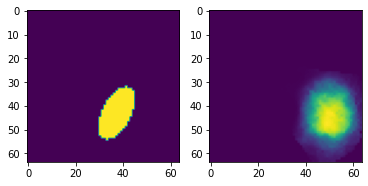

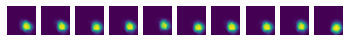

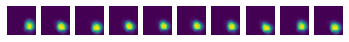

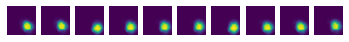

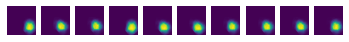

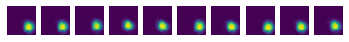

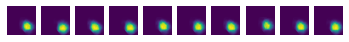

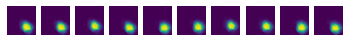

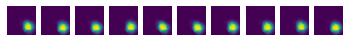

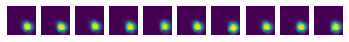

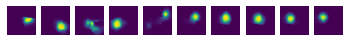

In [ ]:
# 33
sample = np.array([testX[76]])

x = dense1(sample)
x = dense2(x)
m = dense_m(x)
v = dense_v(x)
x = m + 5 * v * tf.random.normal(v.shape)
x = dense4(x)
x = dense5(x)
y = dense6(x)

fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(sample.reshape(img_size, img_size))
fig.add_subplot(1, 2, 2)
plt.imshow(y.numpy().reshape(img_size, img_size))
plt.show()

for changing_num in range(h_units):
  fig = plt.figure()
  for i, changing_val in enumerate(np.arange(0, 1, 0.1)):
    x = dense1(sample)
    x = dense2(x)
    m = dense_m(x)
    v = dense_v(x)
    x = m + 5 * v * tf.random.normal(v.shape)
    x = force_neurons(x.numpy(), [[changing_num, changing_val]])
    x = dense4(x)
    x = dense5(x)
    y = dense6(x)
    
    fig.add_subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(y.numpy().reshape(img_size, img_size))
  plt.show()

In [ ]:
print(m)
print(v)

tf.Tensor(
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.12086143]], shape=(1, 10), dtype=float32)
tf.Tensor(
[[0.16751479 0.1378242  0.9985137  0.98161584 0.07933823 0.22810797
  0.1251755  0.0952498  0.9852684  0.        ]], shape=(1, 10), dtype=float32)


# Conclusion

## Disentangled VAE 
- layers: 128 > 64 > 10
- changes: 0 -> 1, 0.1
- lambda: 0.005

Interesting, the model decided to just learn the x and y position.